In [191]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pcl

In [192]:

calibs_dir = '../sample_data/calibs'
lidar_dir = '../sample_data/points'
image_dir = '../sample_data/images'
label_dir = '../sample_data/labels'

In [193]:
# load pcd data 
# points = np.fromfile(lidar_dir + '/000031.pcd', dtype=np.float32).reshape((-1,4))
# points = points[:, :3]

points = pcl.load('../sample_data/points/000031.pcd')
points = points.to_array()

# load camera
# image = cv2.imread(image_dir + '/000031.png')
image = cv2.cvtColor(cv2.imread(os.path.join(image_dir + '/000031.png')), cv2.COLOR_BGR2RGB)
img_height, img_width, img_channel = image.shape

# load calibration data
calib_file = open(calibs_dir + '/000031.txt', 'r')
calib_lines = calib_file.readlines()

p0 = np.array(calib_lines[0].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p1 = np.array(calib_lines[1].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p2 = np.array(calib_lines[2].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p3 = np.array(calib_lines[3].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)

r0_rect = np.array(calib_lines[4].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 3)
r0_rect = np.insert(r0_rect,3,values=[0,0,0],axis=0)
r0_rect = np.insert(r0_rect,3,values=[0,0,0,1],axis=1)

tr_velo_to_cam = np.array(calib_lines[5].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
tr_velo_to_cam = np.vstack((tr_velo_to_cam, np.array([0, 0, 0, 1], dtype=np.float32)))

tr_imu_to_velo = np.array(calib_lines[6].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)

# load label
label_file = open(label_dir + '/000031.txt', 'r')
labels = label_file.readlines()

In [194]:
print('points: {}\n{}'.format(points.shape, points))
print('image: {}\n{}'.format(image.shape, image))

points: (121291, 3)
[[21.751  2.534  0.95 ]
 [21.762  2.605  0.95 ]
 [21.766  2.675  0.951]
 ...
 [ 7.1   -2.333 -3.369]
 [ 7.105 -2.31  -3.368]
 [ 7.137 -2.296 -3.38 ]]
image: (375, 1242, 3)
[[[133 159 244]
  [127 175 255]
  [176 192 255]
  ...
  [ 72  91  69]
  [ 71  93  66]
  [ 75  95  62]]

 [[140 187 238]
  [132 205 254]
  [207 224 255]
  ...
  [ 49  82  72]
  [ 58  83  74]
  [ 75  87  78]]

 [[179 223 236]
  [169 223 251]
  [210 239 255]
  ...
  [ 74  88  81]
  [103 108  88]
  [152 129  92]]

 ...

 [[ 24  28  43]
  [ 24  28  37]
  [ 23  29  35]
  ...
  [255  58  36]
  [255  58  35]
  [255  58  36]]

 [[ 23  25  31]
  [ 23  26  32]
  [ 23  27  32]
  ...
  [255  56  40]
  [255  58  41]
  [255  59  40]]

 [[ 25  27  27]
  [ 25  27  31]
  [ 23  28  33]
  ...
  [255  56  40]
  [255  57  42]
  [255  58  42]]]


In [195]:
def lidar2cam(p2, r0_rect, tr_velo_to_cam, points):
    points = np.vstack((points, np.ones((1, points.shape[1]))))
    print(points.shape)

    lidar_cam = p0 @ r0_rect @ tr_velo_to_cam @ points
    lidar_cam[:2, :] /= lidar_cam[2, :]
    return lidar_cam[:2, :]

(4, 121291)


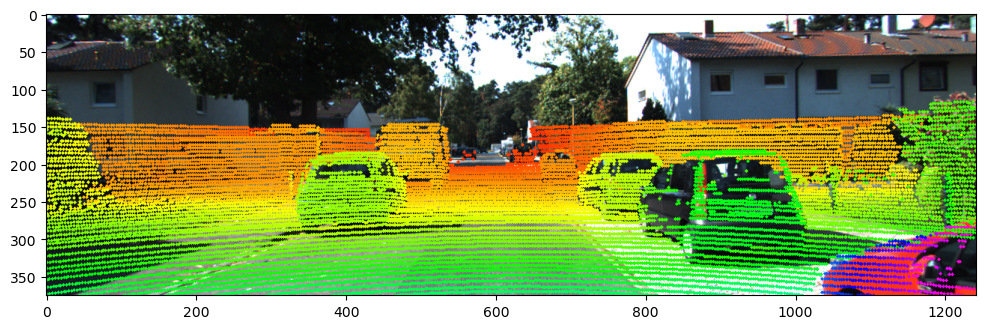

In [196]:
lidar_cam = lidar2cam(p2, r0_rect, tr_velo_to_cam, points.T)

# lidar_cam is less than the width and height of the image
# points_x is positive number
inds = np.where((lidar_cam[0, :] < img_width) & (lidar_cam[0, :] >= 0) &
                    (lidar_cam[1, :] < img_height) & (lidar_cam[1, :] >= 0) &
                    (points[:, 0] > 0)
                    )[0]

# Filter out pixels points
imgfov_pc_pixel = lidar_cam[:, inds]

# Retrieve depth from lidar
imgfov_pc_velo = points[inds, :]
imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
imgfov_pc_cam2 = (p0 @ r0_rect @ tr_velo_to_cam) @ imgfov_pc_velo.T

cmap = plt.cm.get_cmap('hsv', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

lidar_on_image = image.copy()
for i in range(imgfov_pc_pixel.shape[1]):
    depth = imgfov_pc_cam2[2, i]
    color = cmap[int(640.0 / depth), :]
    cv2.circle(lidar_on_image, (int(np.round(imgfov_pc_pixel[0, i])),
                        int(np.round(imgfov_pc_pixel[1, i]))),
                2, color=tuple(color), thickness=-1)

plt.figure(figsize=(12, 12))
plt.imshow(lidar_on_image)
    

In [197]:
# 1: Car                         : Object Type
# 1: 0.00                        : truncated
# 1: 0                           : occluded
# 1: -1.35                       : alpha
# 4: 334.28 180.65 490.02 297.48 : bbox
# 3: 1.65 1.67 3.81              : dimensions
# 3: -3.18 1.79 12.20            : location
# 1: -1.60                       : rotation_y
# 1: xxx                         : score (optional)

class Label:
    def __init__(self, label):
        self.type = label[0]
        self.truncated = float(label[1])
        self.occluded = float(label[2])
        self.alpha = float(label[3])
        self.bbox = list(map(float, label[4:8]))
        self.dimensions = list(map(float, label[8:11]))
        self.location = list(map(float, label[11:14]))
        self.rotation_y = float(label[14])
        
        if(len(label) == 9):
            self.score = float(label[8])
            
    def __str__(self):
        return 'type: {}, truncated: {}, occluded: {}, alpha: {}, bbox: {}, dimensions: {}, location: {}, rotation_y: {}'.format(
            self.type, self.truncated, self.occluded, self.alpha, self.bbox, self.dimensions, self.location, self.rotation_y
        )

In [198]:
# load label
label_list = []
for label in labels:
    label_list.append(Label(label.strip('\n').split(' ')))
    print(label_list[-1])

type: Car, truncated: 0.0, occluded: 0.0, alpha: -1.35, bbox: [334.28, 180.65, 490.02, 297.48], dimensions: [1.65, 1.67, 3.81], location: [-3.18, 1.79, 12.2], rotation_y: -1.6
type: Car, truncated: 0.0, occluded: 0.0, alpha: -1.93, bbox: [785.85, 179.67, 1028.82, 340.75], dimensions: [1.52, 1.51, 3.1], location: [3.18, 1.61, 8.46], rotation_y: -1.59
type: Car, truncated: 0.0, occluded: 1.0, alpha: -1.8, bbox: [711.98, 179.65, 848.82, 277.62], dimensions: [1.53, 1.58, 3.53], location: [2.9, 1.66, 13.14], rotation_y: -1.59
type: Truck, truncated: 0.0, occluded: 2.0, alpha: 1.71, bbox: [445.91, 131.69, 539.77, 228.36], dimensions: [2.6, 2.06, 5.42], location: [-3.48, 1.52, 22.27], rotation_y: 1.56
type: Car, truncated: 0.0, occluded: 0.0, alpha: -1.64, bbox: [660.82, 178.72, 713.09, 222.03], dimensions: [1.46, 1.6, 3.71], location: [2.71, 1.69, 26.41], rotation_y: -1.54
type: Van, truncated: 0.0, occluded: 0.0, alpha: -1.62, bbox: [620.95, 171.59, 649.36, 200.46], dimensions: [1.97, 1.82,

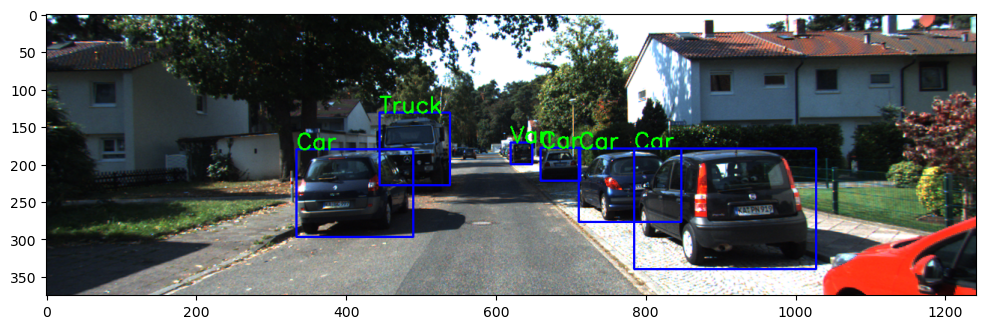

In [199]:
# visualize label on image

object_on_image = image.copy()
for label in label_list:
    if(label.type != 'DontCare'):
        cv2.rectangle(object_on_image, (int(label.bbox[0]), int(label.bbox[1])), (int(label.bbox[2]), int(label.bbox[3])), (0, 0, 255), 2)
        cv2.putText(object_on_image, label.type, (int(label.bbox[0]), int(label.bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(object_on_image)

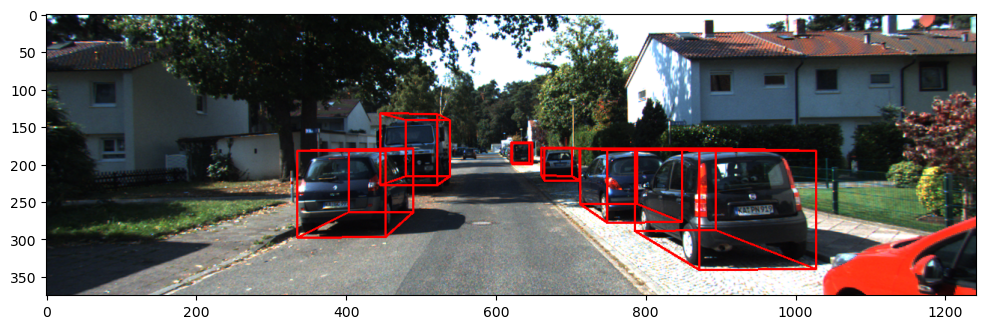

In [200]:
# visualize 3d bounding box on image

def compute_box_3d(dimensions, location, rotation_y):
    R = np.array([[np.cos(rotation_y), 0, np.sin(rotation_y)],
                  [0, 1, 0],
                  [-np.sin(rotation_y), 0, np.cos(rotation_y)]])

    h, w, l = dimensions
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    corners_3d = R @ np.vstack([x_corners, y_corners, z_corners]) + np.array(location).reshape((3, 1))
    return corners_3d

def project_to_image(pts_3d, p2, r0_rect, tr_velo_to_cam):
    pts_3d_h = np.vstack((pts_3d, np.ones(pts_3d.shape[1])))
    pts_2d = p2 @ pts_3d_h
    pts_2d = pts_2d / pts_2d[2, :]
    return pts_2d[:2, :]

object_3d_on_image = image.copy()
for label in label_list:
    if(label.type != 'DontCare'):
        box_3d = compute_box_3d(label.dimensions, label.location, label.rotation_y)
        box_2d = project_to_image(box_3d, p2, r0_rect, tr_velo_to_cam)
        box_2d = np.array(box_2d, dtype=np.int32)

        for i in range(4):
            cv2.line(object_3d_on_image, (box_2d[0, i], box_2d[1, i]), (box_2d[0, (i + 1) % 4], box_2d[1, (i + 1) % 4]), (255, 0, 0), 2)
            cv2.line(object_3d_on_image, (box_2d[0, i + 4], box_2d[1, i + 4]), (box_2d[0, (i + 1) % 4 + 4], box_2d[1, (i + 1) % 4 + 4]), (255, 0, 0), 2)
            cv2.line(object_3d_on_image, (box_2d[0, i], box_2d[1, i]), (box_2d[0, i + 4], box_2d[1, i + 4]), (255, 0, 0), 2)
                
plt.figure(figsize=(12, 12))
plt.imshow(object_3d_on_image)


In [208]:
# top view

ratio = 0.05

img_width = 1200
img_height = 2500

top_view = np.zeros((img_height, img_width, 3), dtype=np.uint8)

print('origin points: ', points.shape)

img_points = points.copy()
img_points[:, 1] = (points[:, 0] / ratio) + img_height / 2
img_points[:, 0] = (points[:, 1] / ratio) + img_width / 2

inds = np.where((img_points[:, 0] < img_width) & (img_points[:, 0] >= 0) &
                    (img_points[:, 1] < img_height) & (img_points[:, 1] >= 0))[0]

top_view_points = img_points[inds, :]
print('top view points:', top_view_points.shape)

for point in top_view_points:
    cv2.circle(top_view, (int(point[0]), int(point[1])), 1, (255, 255, 255), -1)

# plt.figure(figsize=(12, 12))
# plt.axis('off')
# plt.imshow(top_view)

origin points:  (121291, 3)
top view points: (120678, 3)


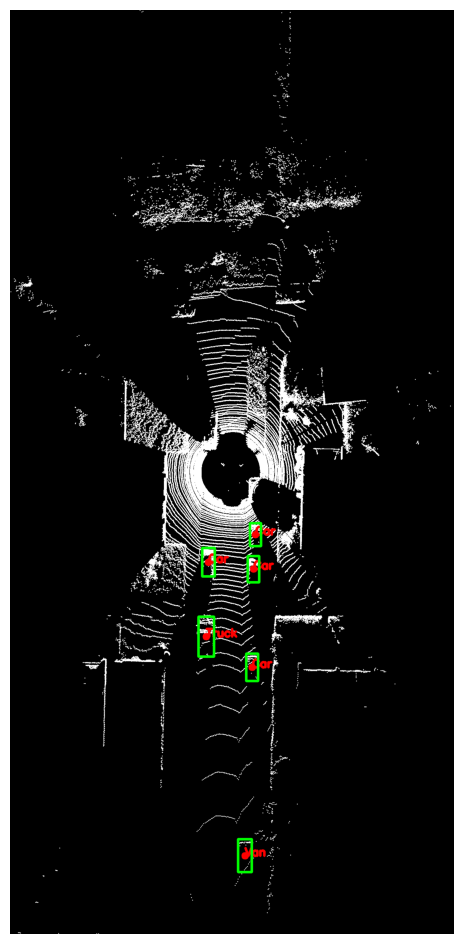

In [209]:

# object box on top view

top_view_points_with_box = top_view.copy()
top_view_points_with_box = cv2.flip(top_view_points_with_box, 1)

for label in label_list:
    if(label.type != 'DontCare'):
        x, y = label.location[0], label.location[2]
        lidar_x = np.linalg.inv(r0_rect) @ np.linalg.inv(tr_velo_to_cam) @ np.array([x, label.location[1], y, 1])
        
        w, l = label.dimensions[1], label.dimensions[2]
        
        x = x / ratio + img_width / 2
        y = y / ratio + img_height / 2
        
        cv2.putText(top_view_points_with_box, label.type, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 5)
        cv2.circle(top_view_points_with_box, (int(x), int(y)), 10, (255, 0, 0), -1)
        cv2.rectangle(top_view_points_with_box, (int(x - w / 2 /ratio), int(y - l / 2 /ratio)), (int(x + w / 2 /ratio), int(y + l / 2 /ratio)), (0, 255, 0), 5)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(top_view_points_with_box)